<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/exploring_emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import minimize

In [ ]:
! pip install emcee
! pip install corner

import emcee
import corner

!clear

     |████████████████████████████████| 51kB 2.6MB/s 


# Данные

Подгрузим все данные.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

#lensPlane1=fits.open("maps/IRIS417.fits")[0].data
#lensPlane2=fits.open("maps/IRIS314.fits")[0].data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/IKI/Микролинзирование


Незашумленные кривые блеска:

In [ ]:
filename = 'data/refE5R50M20Ni2m2b5m3Z01_h5.ubv' 
model_curves = pd.read_csv(filename, header=0, delim_whitespace=True)

t1 = np.array(model_curves.time.values)      
lc1 = np.array(model_curves.F160W.values)

t_min = 20
cadence = 98 #test

t1_grid = np.linspace(t_min, np.max(t1), cadence) # зададим сетку, чтобы точно контролировать количество точек и временной интервал
m1 = np.interp(t1_grid, t1, lc1)  # линейная интерполяция кривой lc1 на новую сетку t1_grid

Сдвинем кривую по времени и магнитуде:

In [ ]:
dt_true = 10.            

magn_ratio = 1.14

dm_true = -2.5*np.log10(magn_ratio)
print(dm_true)

t2_grid = t1_grid + dt_true # второе изображение
m2 = m1 + dm_true

-0.14226212834118138


Функция для единого оформления графиков:

In [ ]:
from matplotlib import rcParams

def grafik():
  
  rcParams['figure.figsize'] = (7,5)
  plt.title('Кривые блеска SN Refsdal', fontsize=15)
  plt.xlabel('Время (в днях) с момента взрыва сверхновой', fontsize=15)
  plt.ylabel('Блеск', fontsize=15)
  plt.ylim(28.5, 26)
  plt.legend()
  plt.grid()
  plt.show()

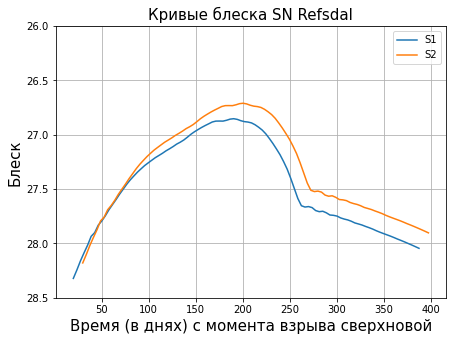

In [ ]:
plt.plot(t1_grid, m1, label="S1")
plt.plot(t2_grid, m2, label="S2")

grafik()

# Добавляем микролинзирование

Добавим шум:

In [ ]:
fluct1 = pd.read_csv('data/micro_data417.csv').to_numpy()
fluct2 = pd.read_csv('data/micro_data314.csv').to_numpy()
length=98

In [ ]:
pd.DataFrame(fluct1).drop([i for i in range(5,3+length-2)], axis=1).drop([i for i in range(3+length+2,3+2*length-2)], axis=1).drop([i for i in range(3+2*length+2,3+3*length-2)], axis=1)

,0,1,2,3,4,99,100,101,102,197,198,199,200,295,296
0,672.0,503.0,98.0,0.0,1.0,96.0,97.0,0.062778,0.056966,-0.088485,-0.089583,0.185339,0.179476,-0.041963,-0.043252
1,539.0,690.0,98.0,0.0,1.0,96.0,97.0,0.008115,0.012606,-0.029115,-0.029899,0.038614,0.043052,-0.131755,-0.134332
2,460.0,868.0,98.0,0.0,1.0,96.0,97.0,0.017151,0.018060,-0.055915,-0.057639,0.066605,0.067468,-0.381019,-0.386998
3,597.0,184.0,98.0,0.0,1.0,96.0,97.0,0.057644,0.043036,-0.161567,-0.165207,0.268946,0.254269,-0.261480,-0.260500
4,112.0,480.0,98.0,0.0,1.0,96.0,97.0,-0.574903,-0.408679,0.005603,0.006410,-0.610021,-0.442461,0.159879,0.163136
5,200.0,682.0,98.0,0.0,1.0,96.0,97.0,0.022497,0.014445,-0.057409,-0.059848,0.049694,0.041816,-0.504251,-0.507932
6,181.0,620.0,98.0,0.0,1.0,96.0,97.0,-0.703499,-0.749691,0.046356,0.046666,-0.756636,-0.802788,0.058315,0.060723
7,722.0,473.0,98.0,0.0,1.0,96.0,97.0,0.052433,0.046954,0.005950,0.006928,0.010341,0.004883,0.131215,0.132212
8,667.0,610.0,98.0,0.0,1.0,96.0,97.0,0.262862,0.270301,-0.196106,-0.197635,0.466419,0.473875,0.024501,0.025486
9,222.0,104.0,98.0,0.0,1.0,96.0,97.0,0.092063,0.095051,-0.223296,-0.227509,0.367657,0.370756,-0.293901,-0.296330


In [ ]:
xxs1 = fluct1[:, 0]
yys1 = fluct1[:, 1]
lengths1 = fluct1[:,2].astype(int)
time_grids1 = fluct1[:, 3:3+length]
dm_gausss1 = fluct1[:, 3+length:3+2*length]
dm_flats1 = fluct1[:, 3+2*length:3+3*length]

In [ ]:
pd.DataFrame(fluct2).drop([i for i in range(5,3+length-2)], axis=1).drop([i for i in range(3+length+2,3+2*length-2)], axis=1).drop([i for i in range(3+2*length+2,3+3*length-2)], axis=1)

,0,1,2,3,4,99,100,101,102,197,198,199,200,295,296
0,446.0,152.0,98.0,0.0,1.0,96.0,97.0,-0.006463,-0.011868,0.064931,0.066147,-0.094046,-0.099483,0.138851,0.141141
1,582.0,811.0,98.0,0.0,1.0,96.0,97.0,0.578026,0.587022,0.166787,0.170915,0.283181,0.291970,0.379634,0.384101
2,412.0,554.0,98.0,0.0,1.0,96.0,97.0,-0.737375,-0.519577,-0.247249,-0.252805,-0.301132,-0.081629,-0.104625,-0.102588
3,306.0,478.0,98.0,0.0,1.0,96.0,97.0,1.562555,1.568616,-0.208951,-0.210525,1.798768,1.804360,0.015436,0.015193
4,609.0,414.0,98.0,0.0,1.0,96.0,97.0,0.667663,0.511442,-0.451061,-0.458883,1.267988,1.110342,-0.502039,-0.508006
5,641.0,694.0,98.0,0.0,1.0,96.0,97.0,0.597718,0.592885,-0.244210,-0.248009,0.911994,0.907743,-0.252104,-0.251089
6,536.0,844.0,98.0,0.0,1.0,96.0,97.0,0.337492,0.307507,-0.113581,-0.114352,0.396275,0.365700,0.082792,0.086746
7,571.0,782.0,98.0,0.0,1.0,96.0,97.0,1.141733,1.197750,-0.142214,-0.143083,1.278458,1.334809,0.071215,0.073677
8,359.0,402.0,98.0,0.0,1.0,96.0,97.0,0.199365,0.182726,0.042624,0.044629,0.057513,0.040913,0.162603,0.158059
9,759.0,415.0,98.0,0.0,1.0,96.0,97.0,1.160922,1.161087,-0.319367,-0.323717,1.548577,1.549557,-0.303033,-0.305195


In [ ]:
xxs2 = fluct2[:, 0]
yys2 = fluct2[:, 1]
lengths2 = fluct2[:,2].astype(int)
time_grids2 = fluct2[:, 3:3+length]
dm_gausss2 = fluct2[:, 3+length:3+2*length]
dm_flats2 = fluct2[:, 3+2*length:3+3*length]

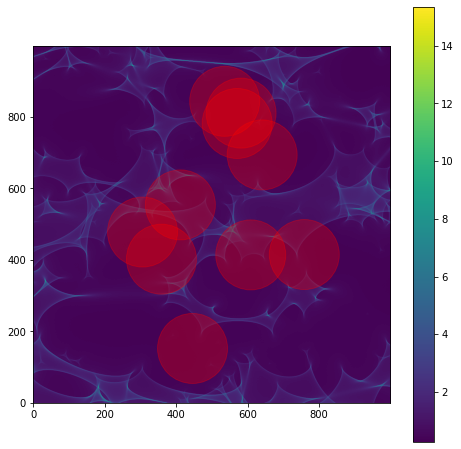

In [ ]:
map_number = 417

image_data = fits.getdata("maps/IRIS"+str(map_number)+".fits")
image = 10**(.4*(image_data-1024)/256.0)

plt.figure(figsize=(8,8))
plt.imshow(image, origin='lower')
plt.colorbar()


for j in range(0, len(fluct2)):

  xx = xxs2[j]
  yy = yys2[j]
  length = lengths2[j]
  time_grid = time_grids2[j]
  dm_gauss = dm_gausss2[j]
  dm_flat = dm_flats2[j]
 
  plt.gca().add_patch( plt.Circle((xx,yy), length, color='red', alpha=0.3) )

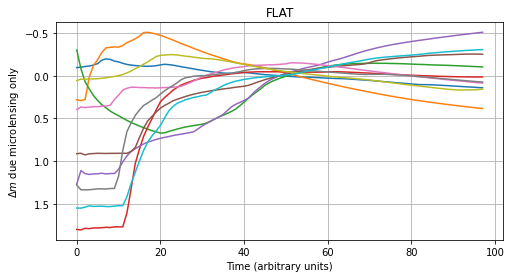

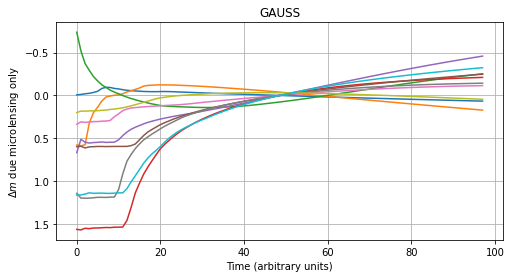

In [ ]:
plt.figure(figsize=(8,4))

for j in range(0, len(fluct2)):

  xx2 = xxs2[j]
  yy2 = yys2[j]
  time_grid2 = time_grids2[j]
  dm_gauss2 = dm_gausss2[j]
  dm_flat2 = dm_flats2[j]
  
  #print('Number', j, ', center = (', xx, ',', yy,')')
  
  #plt.plot(time_grid, dm_gauss, label='gauss')
  plt.plot(time_grid2, dm_flat2, label='flat')
  #plt.axhline(np.median(dm_gauss), color='r', linestyle='--', label='gauss mean')
  #plt.axhline(np.median(dm_flat), color='g', linestyle='--', label='flat mean')
plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
plt.title('FLAT')
#plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,4))

for j in range(0, len(fluct2)):

  xx2 = xxs2[j]
  yy2 = yys2[j]
  time_grid2 = time_grids2[j]
  dm_gauss2 = dm_gausss2[j]
  dm_flat2 = dm_flats2[j]
  
  #print('Number', j, ', center = (', xx, ',', yy,')')
  
  plt.plot(time_grid2, dm_gauss2, label='gauss')
  #plt.plot(time_grid, dm_flat, label='flat')
  #plt.axhline(np.median(dm_gauss), color='r', linestyle='--', label='gauss mean')
  #plt.axhline(np.median(dm_flat), color='g', linestyle='--', label='flat mean')
plt.title('GAUSS')
plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
#plt.legend()
plt.grid()
plt.show()

In [ ]:
#microlensing_noise1 = -2.5*np.log10(dm_gauss[8]) #np.random.normal(0., 0.1, len(t1_grid)) 
#microlensing_noise2 = -2.5*np.log10(dm_gauss[5]) #np.random.normal(0., 0.1, len(t2_grid))

lc1_noise = m1 + dm_flats1[8]# microlensing_noise1
lc2_noise = m2 + dm_flats1[9]#microlensing_noise2

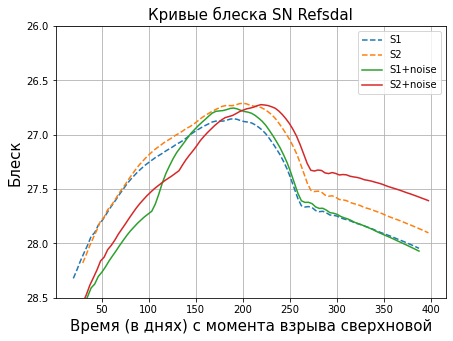

In [ ]:
plt.plot(t1_grid, m1, linestyle='--', label="S1")
plt.plot(t2_grid, m2, linestyle='--', label="S2")

plt.plot(t1_grid, lc1_noise, label="S1+noise")
plt.plot(t2_grid, lc2_noise, label="S2+noise")

#lc2_noise_shifted = np.interp(t1_grid + dt_true, t2_grid, lc2_noise) - dm_true
#plt.plot(t1_grid, lc2_noise_shifted, label="S2 shifted")

grafik()

# emcee

Зададим необходимые функции. Логика следующая: мы "кормим" алгоритм данными из изображения S2, а потом сдвигаем их по времени и магнитуде и сравниваем с изображением S1.

In [ ]:
def model(params, x1, x2, y2):
    dt, dmu = params
    #func = interpolate.interp1d(x2, y2)
    #return func(x1 + dt) - dmu
    return np.interp(x1 + dt, x2, y2) - dmu

def lnlike(params, x1, y1, x2, y2):
    dt, dmu = params
    lnlike = -0.5 * np.sum( ( (y1 - model(params, x1, x2, y2))/1 )**2 )# + np.log(2*np.pi*sigmu**2) )
    return lnlike

def lnprior(params):
    dt, dmu = params
    if (0. < dt < 100. and -5. < dmu < 5. ):
        return 0.0
    return -np.inf

def lnprob(params, x1, y1, x2, y2):
    lp = lnprior(params)
    if np.isfinite(lp):
      return lp + lnlike(params, x1, y1, x2, y2)
    else:
      return -np.inf

In [ ]:
def best_with_MCMC(dtTrue, dmTrue, lengthofchain, arguments, draw):

  #np.random.seed(45)
  #lnlike1 = lambda *args: -lnlike(*args)
  #initial = np.array([dtTrue, dmTrue]) + 0.01 * np.random.randn(2)
  #optim = minimize(lnlike1, initial, args=arguments)
  
  nwalkers = 100
  initial = [dtTrue, dmTrue]
  ndim = len(initial)
  p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = arguments )
  #p0, _, _ = sampler.run_mcmc(p0, 500, progress=True)
  #sampler.reset()
  sampler.run_mcmc(p0, lengthofchain, progress = True)

  samples = sampler.flatchain
  s  = samples[np.argmax(sampler.flatlnprobability)]

  #print("Initial dt = {0:.3f}".format(initial[0]))
  #print("Initial dm = {0:.3f}".format(initial[1]))
  #print("sigmu = {0:.3f}".format(optim.x[2]))

  #print('Best dt = {0:.3f}'.format(s[0]))
  #print('Best dmu = {0:.3f}'.format(s[1])) 
  #print('or best magnification ratio = {0:.3f}'.format(10**(-0.4*s[1])) )

  if draw:
        
    plt.plot(arguments[0], arguments[1], label='S1')
    plt.plot(arguments[2], arguments[3], label='S2')
    #if show_all:
    #  for s in samples[np.random.randint(len(samples), size=50)]:
    #    plt.plot(arguments[0], model(s, arguments[0], arguments[2], arguments[3]), color="r", alpha=0.1)
    #else:
    best_fit_model = model(s, arguments[0], arguments[2], arguments[3])
    plt.plot(arguments[0], best_fit_model, color="r", label='Best fit')
    grafik()

    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    chain = sampler.get_chain()
    labels = ['$\Delta t$', '$\Delta m$', '$\sigma_m$']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(chain[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(chain))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    #tau = sampler.get_autocorr_time()
    #print(tau)
    #flat_samples = sampler.get_chain()#discard=400, thin=1, flat=False)
    #print(flat_samples.shape)
  
    fig = corner.corner(sampler.flatchain, 
                        show_titles=True, 
                        labels=['$\Delta t$', '$\Delta m$'], 
                        truths=[dt_true, dm_true], 
                        scale_hist=True, 
                        quantiles=[0.16, 0.5, 0.84])

  return s[0], s[1]

In [ ]:
#best_dt, best_dm = best_with_MCMC(dtTrue=dt_true, 
#                                  dmTrue=dm_true, 
#                                  lengthofchain=1000, 
#                                  arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
#                                  draw=False)

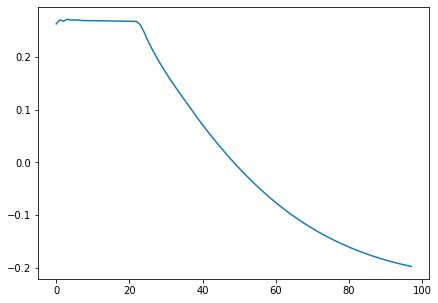

In [ ]:
dm_flat1 = dm_flats1[8]
dm_gauss1 = dm_gausss1[8]
time_grid1 = time_grids1[8]


plt.plot(time_grid1, dm_gauss1)

In [ ]:
best_dt = []
best_dm = []

for i in range(0, len(fluct1)):
  for j in range(0, len(fluct2)):

    dm_gauss1 = dm_gausss1[i]
    dm_gauss2 = dm_gausss2[j]
    dm_flat1 = dm_flats1[i]
    dm_flat2 = dm_flats2[j]

    #МЕНЯТЬ ЗДЕСЬ

    microlensing_noise1 = dm_flat1
    microlensing_noise2 = dm_flat2

    lc1_noise = m1 + microlensing_noise1
    lc2_noise = m2 + microlensing_noise2

    best_dt1, best_dm1 = best_with_MCMC(dtTrue=dt_true, 
                                    dmTrue=dm_true, 
                                    lengthofchain=1000, 
                                    arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
                                    draw = False)
  
    best_dt.append(best_dt1)
    best_dm.append(best_dm1)

100%|██████████| 1000/1000 [00:04<00:00, 240.98it/s]


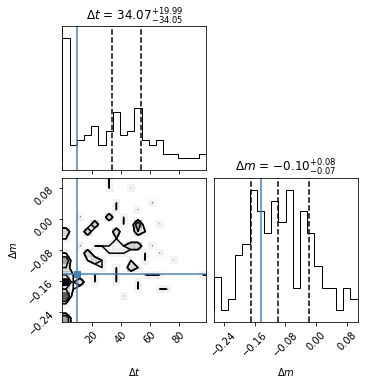

In [ ]:
fig = corner.corner(np.transpose([best_dt, best_dm]), 
                    show_titles=True, 
                    labels=['$\Delta t$', '$\Delta m$'], 
                    truths=[dt_true, dm_true], 
                    scale_hist=True, 
                    quantiles=[0.16, 0.5, 0.84])